<a href="https://colab.research.google.com/github/Denko/Customer_Employee_Happiness/blob/master/PYTH225_Project_Where's_the_happiness%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Happy employees, happy customers: Where are they?</h1>

Bernie says companies exploit workers and gouge customers. CEOs see love all around: grateful and fulfilled workers, satisfied and loyal customers.

The truth? It all depends.

In this project, I'll create 2x2 scatter plots by industry and find companies that score well (and not as well) on both dimensions. The two axes will measure:

*   Customer satisfaction as shown by the [American Customer Satisfaction Index (ASCI)](https://en.wikipedia.org/wiki/American_Customer_Satisfaction_Index), and

*   Employee satisfaction as shown by [Glassdoor](https://en.wikipedia.org/wiki/Glassdoor) ratings.

## <h2>The output</h2>
I created a model in Tableau for [fast food companies](https://drive.google.com/uc?id=1E5G-uP2j6kQ3CCG2A6eOVZRWnuFg1KfU). The goal of this project will be to create something similar - as well as, ideally, to do some additonal exploratory data analysis on the measures - using Python.

## <h2>The data</h2>
Grabbing the ACSI data, which measures customer satisfaction by industry, is a matter of [copying, pasting, and doing a little parsing](https://www.theacsi.org/index.php?option=com_content&view=article&id=149&catid=&Itemid=214&i=Airlines). It's an Excel job.

Getting Glassdoors rating is tougher. There's no way to search on companies using a standardized identifier like ticker, and each rating is buried within the html on the company's Glassdoor page. (See the rating for [General Assembly, 3.6 out of five (not bad)](https://www.glassdoor.com/Reviews/General-Assembly-Reviews-E459214.htm), based on 388 reviews, a number suggesting [some degree of credibilty](https://www.wsj.com/articles/companies-manipulate-glassdoor-by-inflating-rankings-and-pressuring-employees-11548171977).)

I'll try to scrape the Glassdoor ratings. Most likely I will end up collecting this data manually. Tediously.

## <h2>Methodology</h2>

1.   Grab the data for at least 3-4 industries (ideally more).
2.   Save it on Google Drive as a csv file.
3.   Convert the Glassdoor ratings to a 1-100 scale, so they are comparable to the ACSI ratings.
3.   Find some summary statistics for both the ACSI and Glassdoor measures, as a group and by industry (average, median, max, min).
4.   Using matplotlib or a similar library, create scatter plots by industry and across all industries, scaling the axes using the max and min for the data sets.
6.   Using the medians, divide the scatter plots into four quadrants: happy employees and customers, unhappy employees and customers, and a mix of the two.
7.   Label the scatter plots appropriately.

# The data

Bring in the data and store it in a dataframe.

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Next code is from https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1PASwl5-MrBwbxJxH5SmgXTm2P-hVZqsk'
fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('company_love.csv')  
ratings = pd.read_csv('company_love.csv')
# Dataset is now stored in a Pandas Dataframe

Describe the data:

*   269 companies

*   "Customer Satisfaction" shows how the companies are rated on a scale of 0-100 according to the ACSI (American Customer Satisfaction Index)
*   Six ratings of employee satisfaction from Glassdoor employee reviews: Overall satisfaction, Compensation & Benefits, Culture & Values, Career Opportunities, Work-Life Balance, and ratings of Senior Management
*   The number of reviews the Glassdoor ratings are based on, both English-language reviews and total reviews
*   Two columns of random numbers (we'll use these later).

In [87]:
print(ratings.Industry,ratings.Company)

0                        Airlines
1                        Airlines
2                        Airlines
3                        Airlines
4                        Airlines
                  ...            
264    Wireless Telephone Service
265    Wireless Telephone Service
266    Wireless Telephone Service
267    Wireless Telephone Service
268    Wireless Telephone Service
Name: Industry, Length: 269, dtype: object 0                 Alaska
1               American
2                  Delta
3               Frontier
4                JetBlue
             ...        
264               Sprint
265             T-Mobile
266    TracFone Wireless
267        U.S. Cellular
268     Verizon Wireless
Name: Company, Length: 269, dtype: object


In [4]:
ratings.describe()

,Customer Satisfaction,Overall Employee,Comp & Benefits,Culture & Values,Career Opportunities,Work-Life Balance,English Reviews,Total Reviews,Random Big,Random Small
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,77.081784,3.492193,3.455390,3.423420,3.227881,3.363941,4116.486989,4567.501859,0.014836,-0.000695
std,4.437880,0.393101,0.514653,0.480681,0.393230,0.426458,6749.994289,7282.615862,0.288619,0.029673
min,57.000000,2.100000,1.800000,1.800000,1.600000,1.800000,2.000000,2.000000,-0.493000,-0.049000
25%,75.000000,3.200000,3.000000,3.100000,3.000000,3.100000,470.000000,577.000000,-0.244000,-0.027000
50%,78.000000,3.500000,3.600000,3.400000,3.200000,3.400000,1873.000000,2055.000000,0.035000,-0.003000
75%,80.000000,3.800000,3.800000,3.800000,3.500000,3.700000,4500.000000,4957.000000,0.274000,0.026000
max,86.000000,4.500000,4.700000,4.600000,4.400000,4.700000,46577.000000,50714.000000,0.498000,0.050000


Show the number of companies per industry category.

In [20]:
print('Companies per Industry\n')
print(ratings['Industry'].value_counts())

Companies per Industry

Specialty Retail Stores                26
Investor-Owned Energy Utilities        25
Supermarkets                           19
Limited-Service Restaurants            15
Automobiles and Light Vehicles         14
Internet Retail                        13
Banks                                  13
Video Streaming Service                11
Full-Service Restaurants               11
Food Manufacturing                     10
Personal Computers                      9
Airlines                                8
Property and Casualty Insurance         8
Hotels                                  8
Department and Discount Stores          7
Internet News and Opinion               7
Internet Investment Services            6
Personal Care and Cleaning Products     6
Health Insurance                        6
Wireless Telephone Service              6
Internet Social Media                   5
Video-on-Demand Service                 5
Financial Advisors                      5
Life Insur

# How industries fare

Using the ACSI ratings, let's look at the industries that customers like the most. (Can you guess what industry they hate?) 

In [23]:
sum_table = ratings.groupby(['Industry'])['Customer Satisfaction'].describe()[['count', 'mean','max','min']].sort_values('mean', ascending=False)
print(sum_table)


                                     count       mean   max   min
Industry                                                         
Soft Drinks                            3.0  81.666667  82.0  81.0
Food Manufacturing                    10.0  81.500000  84.0  80.0
Personal Care and Cleaning Products    6.0  80.333333  84.0  77.0
Household Appliances                   5.0  80.200000  82.0  79.0
Internet Investment Services           6.0  80.000000  81.0  78.0
Life Insurance                         5.0  79.800000  82.0  78.0
Apparel                                4.0  79.750000  83.0  77.0
Internet Retail                       13.0  79.307692  82.0  73.0
Supermarkets                          19.0  79.210526  84.0  73.0
Financial Advisors                     5.0  79.200000  80.0  78.0
Full-Service Restaurants              11.0  79.090909  83.0  77.0
Internet Travel Services               3.0  79.000000  82.0  76.0
Automobiles and Light Vehicles        14.0  78.785714  83.0  71.0
Property a

What about employees? Let's look at the industries employees most love and hate.

In [26]:
sum_table_emp = ratings.groupby(['Industry'])['Overall Employee'].describe()[['count', 'mean','max','min']].sort_values('mean', ascending=False)
print(sum_table_emp)

                                     count      mean  max  min
Industry                                                      
Internet Social Media                  5.0  3.900000  4.4  3.4
Personal Care and Cleaning Products    6.0  3.850000  4.0  3.3
Airlines                               8.0  3.837500  4.3  3.3
Personal Computers                     9.0  3.833333  4.4  3.3
Hotels                                 8.0  3.800000  4.5  3.0
Video Streaming Service               11.0  3.736364  4.4  2.9
Food Manufacturing                    10.0  3.670000  4.5  3.1
Internet Investment Services           6.0  3.666667  3.9  3.2
Internet News and Opinion              7.0  3.600000  3.8  3.0
Financial Advisors                     5.0  3.580000  3.8  3.3
Household Appliances                   5.0  3.580000  4.0  2.9
Soft Drinks                            3.0  3.566667  3.7  3.3
Internet Travel Services               3.0  3.566667  3.8  3.3
Life Insurance                         5.0  3.560000  3

# Do happy employees beget happy customers?

Now it's time to test the idea that when employees are happy, customers are happy too. To what extent is customer satisfaction correlated with employee satisfaction? First we'll look at how customer satisfacton correlates with all six Glassdoor ratings.

In [35]:
# p-value method from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

overall = pearsonr(ratings['Customer Satisfaction'], ratings['Overall Employee']) # 1st value is correlation, 2nd is p-value
comp = pearsonr(ratings['Customer Satisfaction'], ratings['Comp & Benefits'])
values = pearsonr(ratings['Customer Satisfaction'], ratings['Culture & Values'])
growth = pearsonr(ratings['Customer Satisfaction'], ratings['Career Opportunities'])
balance = pearsonr(ratings['Customer Satisfaction'], ratings['Work-Life Balance'])
# boss = pearsonr(ratings['Customer Satisfaction'], ratings['Senior Mgmt'])

print('Correlation of Customer Love with:\n')
print('Employee Satisfaction ',overall)
print('Comp/Benefits ',comp)
print('Culture/Values ',values)
print('Career Opportunities ',growth)
print('Work-Life Balance ',balance)
print('\n(Correlation followed by p-value)')

Correlation of Customer Love with:

Employee Satisfaction  (0.15115807526053038, 0.013068065882048648)
Comp/Benefits  (-0.027966791523934435, 0.6479278153924193)
Culture/Values  (0.22701610243946022, 0.00017323978078320968)
Career Opportunities  (0.09896871715530155, 0.10531236242192746)
Work-Life Balance  (0.10093144486818877, 0.09855272486215864)

(Correlation followed by p-value)


In general, the  correlations are low and insignificant, but there's an exception. There is a relatively high (0.23) and very significant (0.02%) correlation between:

*   how employees rate the company's culture and values
*   how satisfied customers are

The only other significant correlation is between overall employee and overall customer satisfaction, at 0.15 with a p-value of 1.3% - significant but not high.





In [42]:
# ind_cust = ratings.groupby(['Industry'])['Customer Satisfaction']
# ind_empl = ratings.groupby(['Industry'])['Overall Employee']
# corr_ind = pearsonr(ind_cust,ind_empl)

#balance = pearsonr(ratings.groupby(['Industry'])['Customer Satisfaction'], ratings.groupby(['Industry'])['Culture & Values'])


AttributeError: ignored

# Scatterplots

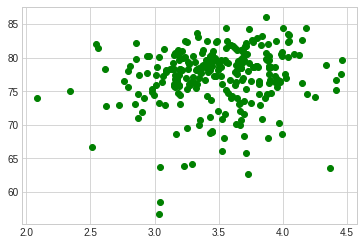

In [81]:
ACSI = ratings['Customer Satisfaction'] + ratings['Random Big']
ACSI_mean = ratings['Customer Satisfaction'].mean
GD = ratings['Overall Employee'] + ratings['Random Small']
GD_mean = ratings['Overall Employee'].mean

plt.style.use('seaborn-whitegrid')
y = ACSI
x = GD
plt.plot(x, y,'o', color='green');

